## Importing Necessary Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics
import scipy.stats as ss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

## Importing Dataset

In [2]:
df  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/Heart_Disease/Training_set_heart.csv" )

## Exploratory Data Analysis

All the values are numerical hence there is no need for encoding the data

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48,1,2,124,255,1,1,175,0,0.0,2,2,2,1
1,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1
2,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
3,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0
4,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1


The dataset is free of any null/NaN values

In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

The following code is used to check the skew of different columns in the dataset. Values for any columns are not heavily skewed hence we can proceed further

d:\python\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


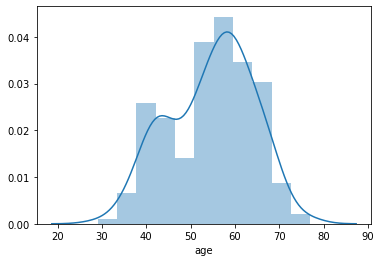

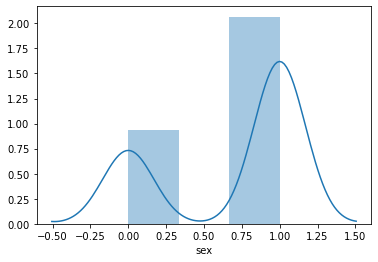

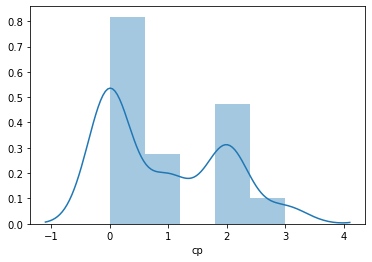

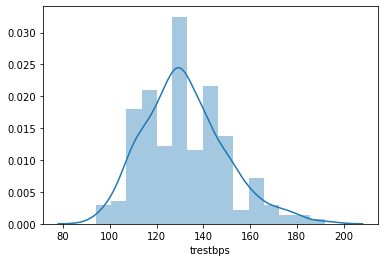

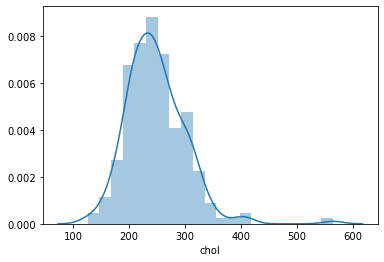

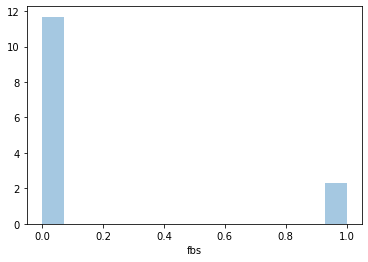

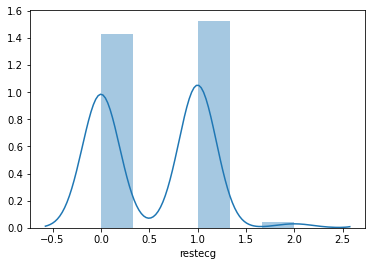

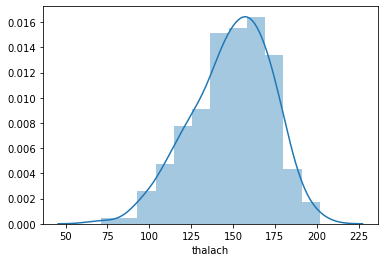

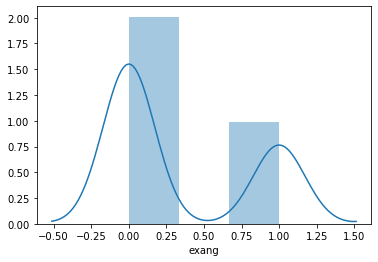

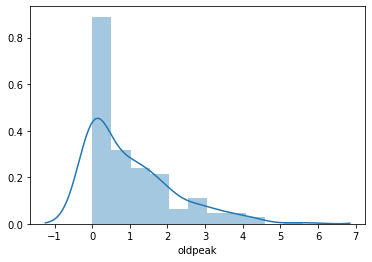

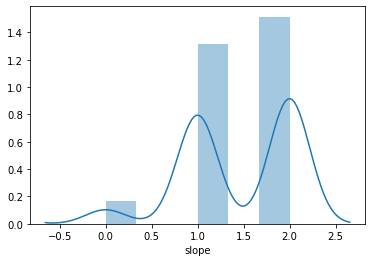

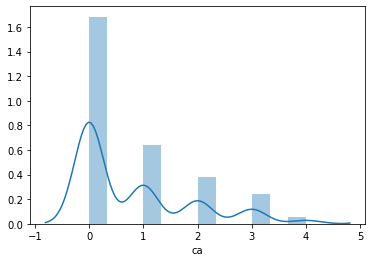

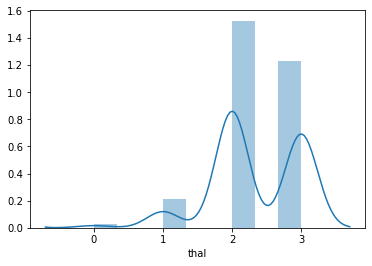

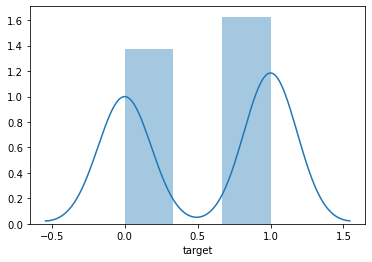

In [5]:
for i, col in enumerate(df.columns):
    plt.figure(i)
    sns.distplot(df[col])

On viewing the statististical description of the dataset, one cannot make out any absurd values straight away. We require further exploration for reaching any conclusive decision

In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,54.561321,0.688679,0.915094,132.127358,247.830189,0.165094,0.537736,148.995283,0.330189,1.008491,1.448113,0.783019,2.320755,0.542453
std,9.493376,0.464130,1.008193,17.440700,53.199877,0.372144,0.527437,23.332645,0.471394,1.141681,0.601850,1.066551,0.646495,0.499374
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.750000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,57.000000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,151.500000,0.000000,0.650000,2.000000,0.000000,2.000000,1.000000
75%,61.250000,1.000000,2.000000,140.000000,277.000000,0.000000,1.000000,165.250000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,192.000000,564.000000,1.000000,2.000000,202.000000,1.000000,5.600000,2.000000,4.000000,3.000000,1.000000


### Corelation Plot
The following heatmap is being used to find the dependency of features in the dataset. Correlated features in general don't improve models , but they affect specific models in different ways and to varying extents:
###### For linear models,
multicolinearity can yield solutions that are wildly varying and possibly numerically unstable.
###### Random Forest
can be good at detecting interactions between different features, but highly correlated features can mask these interactions.

According to Occam's razor, A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of minimum description length makes this more precise.

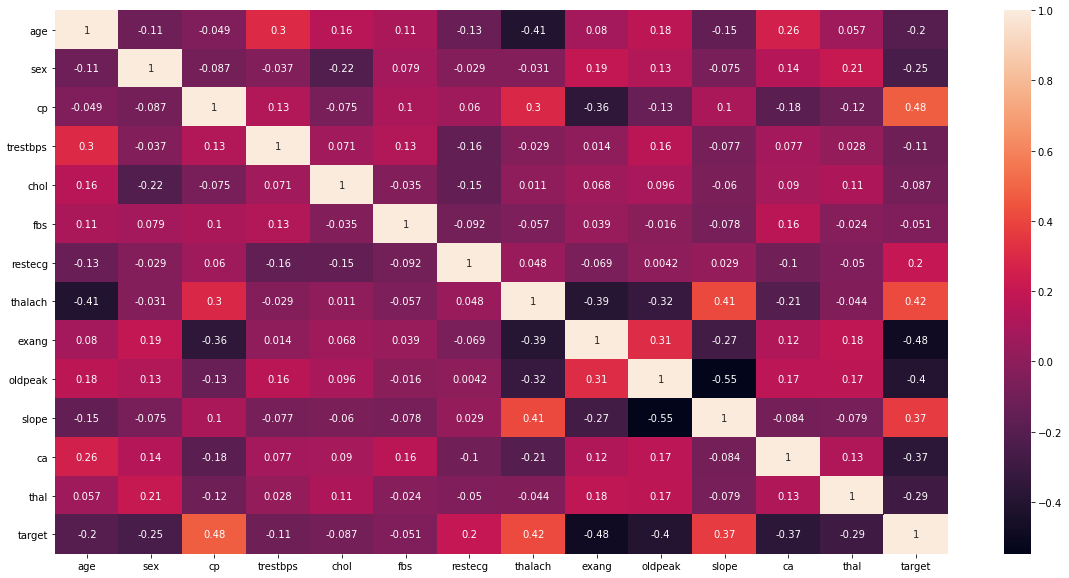

In [7]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(),annot=True)
plt.show()

The code snippet given below is to drop a feature which has a correlation of 0.9 or higher with any other feature. There is no such column in the dataset

In [8]:
# Create correlation matrix
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(to_drop)

[]


###### Unique Values present in every column ( aimed towards categorical data)

In [9]:
for x in df.columns:
    print(x+':'+str(len(df[x].unique())))

age:40
sex:2
cp:4
trestbps:46
chol:134
fbs:2
restecg:3
thalach:82
exang:2
oldpeak:36
slope:3
ca:5
thal:4
target:2


Checking for bias towards a specific gender in terms of weight or in terms of target value

In [10]:
df['sex'].value_counts()

1    146
0     66
Name: sex, dtype: int64

In [11]:
sexbaseddf_1=df['target'][df['sex']==1]

In [12]:
sexbaseddf_1.value_counts()

0    79
1    67
Name: target, dtype: int64

In [13]:
sexbaseddf_2=df['target'][df['sex']==0]

In [14]:
sexbaseddf_2.value_counts()

1    48
0    18
Name: target, dtype: int64

### CHI SQUARE TEST
The purpose of chi square test for independence is to assist us in feature selection. Chi Square test is used to compare two columns ( at a time) and see whether distributions of categorical variables differ from each another

#### This was really helpful in feature selection. We were able to drop unneccary columns and imporve our model

In [15]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, df):
        self.df = df
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = ss.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [16]:
X = df.drop(['target'], axis=1)
ct = ChiSquare(df)
for c in X.columns:
    ct.TestIndependence(c, 'target')

age is NOT an important predictor. (Discard age from model)
sex is IMPORTANT for Prediction
cp is IMPORTANT for Prediction
trestbps is NOT an important predictor. (Discard trestbps from model)
chol is NOT an important predictor. (Discard chol from model)
fbs is NOT an important predictor. (Discard fbs from model)
restecg is IMPORTANT for Prediction
thalach is NOT an important predictor. (Discard thalach from model)
exang is IMPORTANT for Prediction
oldpeak is IMPORTANT for Prediction
slope is IMPORTANT for Prediction
ca is IMPORTANT for Prediction
thal is IMPORTANT for Prediction


###### dropping columns based on chi square test

In [17]:
x_chi = X.drop(['age', 'trestbps','chol','fbs','thalach'],axis=1)

In [18]:
x_chi

,sex,cp,restecg,exang,oldpeak,slope,ca,thal
0,1,2,1,0,0.0,2,2,2
1,0,2,0,0,1.5,1,0,2
2,1,0,0,0,0.8,2,0,3
3,1,0,1,1,1.4,2,1,3
4,1,0,1,0,1.2,1,0,2
...,...,...,...,...,...,...,...,...
207,1,0,0,1,2.6,1,2,3
208,0,3,0,0,1.0,2,0,2
209,1,0,0,1,2.8,1,2,3
210,0,0,1,0,0.0,2,0,2


###### Seperating our target variable

In [19]:
y=df['target']

##### Recursive Feature Elimination
The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. This procedure wasn't helpful in the prediction and dropping columns ranked higher resulted in a drop in accuracy.

###### Hence the results weren't used in train test split

In [20]:
lr = LogisticRegression()
rfe = RFE(estimator=lr, verbose=3)
rfe.fit(x_chi, y)
rfe_df1 = rfe.fit_transform(x_chi, y)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.


In [21]:
print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_chi.columns)))

Features sorted by their rank:
[(1, 'cp'), (1, 'exang'), (1, 'sex'), (1, 'slope'), (2, 'restecg'), (3, 'thal'), (4, 'ca'), (5, 'oldpeak')]


### Checking For Outliers in the dataset
The formula used below is similar to the one used in box-plots. (ie taking the first and third quartile, subreacting them, multiplying the resultant by 1.5 and detecting outliers)

In [22]:
from collections import Counter
def detect_outliers(data,features):
    outlier_indices = []
    for c in features:
        # 1st quartile
        Q1 = np.percentile(data[c],25)
        # 3rd quartile
        Q3 = np.percentile(data[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = data[(data[c] < Q1 - outlier_step) | (data[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

#### No outliers detected in the dataset

In [23]:
df.loc[detect_outliers(df,["age","trestbps","chol","thalach","oldpeak"])]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


####  Train Test Split

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x_chi,y,test_size=0.29,random_state=123)

In [25]:
# Modelling Algorithms
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

#### Comparing results of Machine Learing Algorithms
The following code is used to select the machine learning model that is apt for the prediciton of this dataset. ( Baed on accuracy and f1 score)

In [26]:
models = [LogisticRegression(),LinearSVC(),SVC(kernel='rbf'),KNeighborsClassifier(),RandomForestClassifier(),
        DecisionTreeClassifier(),GradientBoostingClassifier(),GaussianNB() , LinearDiscriminantAnalysis() , 
        QuadraticDiscriminantAnalysis()]

model_names=['LogisticRegression','LinearSVM','rbfSVM','KNearestNeighbors','RandomForestClassifier','DecisionTree',
             'GradientBoostingClassifier','GaussianNB', 'LinearDiscriminantAnalysis','QuadraticDiscriminantAnalysis']

f1 = []
a1=[]
for model in range(len(models)):
    clf = models[model]
    clf.fit(x_train,y_train)
    pred = clf.predict(x_test)
    f1.append(sklearn.metrics.f1_score(pred , y_test))
    a1.append(sklearn.metrics.accuracy_score(pred , y_test))
    
compare = pd.DataFrame({'Algorithm' : model_names , 'F1_score' : f1,'accuracy' : a1})
compare

,Algorithm,F1_score,accuracy
0,LogisticRegression,0.861111,0.838710
1,LinearSVM,0.861111,0.838710
2,rbfSVM,0.873239,0.854839
3,KNearestNeighbors,0.837838,0.806452
4,RandomForestClassifier,0.833333,0.806452
5,DecisionTree,0.782609,0.758065
6,GradientBoostingClassifier,0.828571,0.806452
7,GaussianNB,0.823529,0.806452
8,LinearDiscriminantAnalysis,0.861111,0.838710
9,QuadraticDiscriminantAnalysis,0.845070,0.822581


#### Logestic Regression
Applying the simplest ML model gave us the following results

In [27]:
logreg=LogisticRegression(random_state=23)
logreg.fit(x_train,y_train)
train_pred=logreg.predict(x_train)
test_pred=logreg.predict(x_test)

In [28]:
print('train accuracy:' + str(metrics.accuracy_score(y_train,train_pred)*100))

train accuracy:85.33333333333334


In [29]:
print('test accuracy:' + str(metrics.accuracy_score(y_test,test_pred)*100))

test accuracy:83.87096774193549


In [30]:
print('F1_score on train split:' + str(sklearn.metrics.f1_score(y_test,test_pred)*100))

F1_score on train split:86.11111111111111


In [31]:
cm=sklearn.metrics.confusion_matrix(y_test,test_pred)
cm

array([[21,  6],
       [ 4, 31]], dtype=int64)

#### Tried gridSearchCV for hyperparameter tuning
The results were remained the same

In [32]:
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression(random_state=23)
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy')
grid_clf_acc.fit(x_train, y_train)


d:\python\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "d:\python\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\python\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "d:\python\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
d:\python\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceba

GridSearchCV(estimator=LogisticRegression(random_state=23),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [33]:
#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(x_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(sklearn.metrics.precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(sklearn.metrics.recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(sklearn.metrics.f1_score(y_test,y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
sklearn.metrics.confusion_matrix(y_test,y_pred_acc)

Accuracy Score : 0.8387096774193549
Precision Score : 0.8378378378378378
Recall Score : 0.8857142857142857
F1 Score : 0.8611111111111112


array([[21,  6],
       [ 4, 31]], dtype=int64)

### SVC with kernel= 'rbf'
The results were better as compared to Logestic Regression

In [34]:
sv=SVC(kernel='rbf',random_state=23)
sv.fit(x_train,y_train)
train_pred=sv.predict(x_train)
test_pred=sv.predict(x_test)

In [35]:
print('train accuracy:' + str(metrics.accuracy_score(y_test,test_pred)*100))

train accuracy:85.48387096774194


In [36]:
print('train accuracy:' + str(metrics.accuracy_score(y_train,train_pred)*100))

train accuracy:88.66666666666667


#### Trying Min-Max Scaler to normalize values
Applied min-max scaler to the dataset generally improves result for knn-classification. The dataset followed the same trend.

##### Model Used for prediction

In [37]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_chi = sc.fit_transform(x_chi)

In [38]:
#splitting data once again to apply normalization
x_train,x_test,y_train,y_test=train_test_split(x_chi,y,test_size=0.29,random_state=123)

#### storing  the K nearest neighbors classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Misclassified_sample = []
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    Misclassified_sample.append((y_test != pred_i).sum())
print("Misclassified_sample = ", Misclassified_sample)

Misclassified_sample =  [13, 13, 11, 11, 9, 10, 9, 9, 7, 9, 9, 10, 8, 9, 8, 7, 9, 9, 10, 9, 8, 9, 10, 10, 10, 10, 10, 9, 10]


##### Lowest number of samples for K=9

accuracy_score KNN=9 : 0.8870967741935484


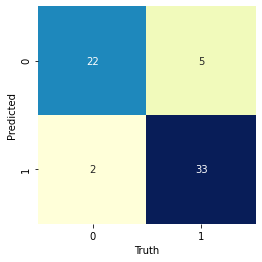

In [40]:
KNN_classifier = KNeighborsClassifier(n_neighbors=9)

# Fitting the values fo X and Y
KNN_classifier.fit(x_train, y_train)

#Predicting the test values with Model
prediction =  KNN_classifier.predict(x_test)

###### confusion matrix  starts ######
from sklearn.metrics import accuracy_score, confusion_matrix
cm_knn = confusion_matrix(y_test,prediction) 
names = np.unique(prediction)
sns.heatmap(cm_knn, square=True, annot=True, cbar=False,xticklabels=names, yticklabels=names, cmap="YlGnBu" ,fmt='g')
plt.xlabel('Truth')
plt.ylabel('Predicted')
###### Confusion matrix ends ########

#calculating the accuracy
accuracy_score = accuracy_score(y_test,prediction)
print("accuracy_score KNN=9 :",accuracy_score)

Final Accuracy on Test Dataset: 88.71%

### Predictions

In [41]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Heart_Disease/Testing_set_heart.csv')

In [42]:
test_data=test_data.drop(['age', 'trestbps','chol','fbs','thalach'],axis=1)

In [43]:
test_data_ft = sc.transform(test_data)

In [44]:
 prr=KNN_classifier.predict(test_data_ft)

In [45]:
res = pd.DataFrame(prr)#preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = test_data.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]
res.to_csv("Assignment2_submission21.csv", index = False) 

### Using shap to Explain the model ( Answering quiz questions)

In [46]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,48,1,2,124,255,1,1,175,0,0.0,2,2,2,1
1,68,0,2,120,211,0,0,115,0,1.5,1,0,2,1
2,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
3,60,1,0,130,253,0,1,144,1,1.4,2,1,3,0
4,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,67,1,0,120,229,0,0,129,1,2.6,1,2,3,0
208,58,0,3,150,283,1,0,162,0,1.0,2,0,2,1
209,60,1,0,145,282,0,0,142,1,2.8,1,2,3,0
210,62,0,0,124,209,0,1,163,0,0.0,2,0,2,1


In [47]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

#### Logestic Regression Model

In [48]:
logreg2=LogisticRegression(random_state=23)
logreg2.fit(x_train,y_train)

d:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=23)

In [49]:
import shap

#### Using linear Explainer for Linear Model

In [50]:
explainer = shap.LinearExplainer(logreg2,x_train)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(x_test)

# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

# displaying the first 5 rows of the shap values table
pd.DataFrame(shap_values).head()

Expected Value: 0.5827125473008811


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.089011,-0.313304,0.706220,-0.921207,0.143881,-0.240893,0.570134,0.187206,0.223136,0.277586,0.47038,0.234643,-0.538719
1,-0.453560,-0.313304,-1.255502,0.507021,0.254880,0.035996,-0.755759,-0.749799,-0.892542,-0.503613,-0.34062,0.234643,-0.538719
2,0.062885,0.533463,-0.274641,0.046302,0.015540,0.035996,-0.755759,0.421457,0.223136,0.537986,-0.34062,-0.191980,0.242033
3,0.214780,0.533463,-1.255502,-0.137985,-0.185644,-0.240893,0.570134,-0.905966,0.223136,-0.451533,-0.34062,-1.045227,0.242033
4,-0.028253,0.533463,0.706220,-0.644776,0.136944,0.035996,0.570134,0.206727,0.223136,0.537986,0.47038,-0.191980,0.242033


#### The following code snippet conveys that cp affects the dataset most (by magnitude)

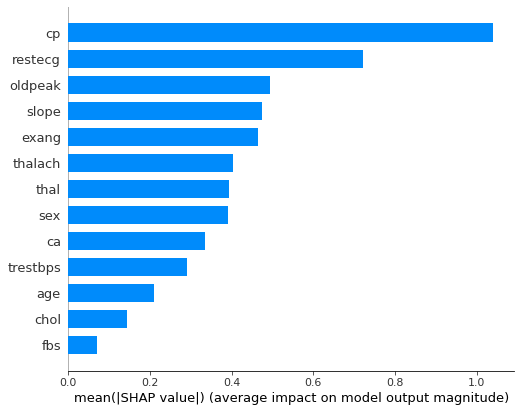

In [51]:
shap.initjs()
shap.summary_plot(shap_values, 
                  x_test, plot_type="bar")

##### The following code snippet conveys that cp and restecg have the most impact in prediction of heart attacj while fbs has the least impact

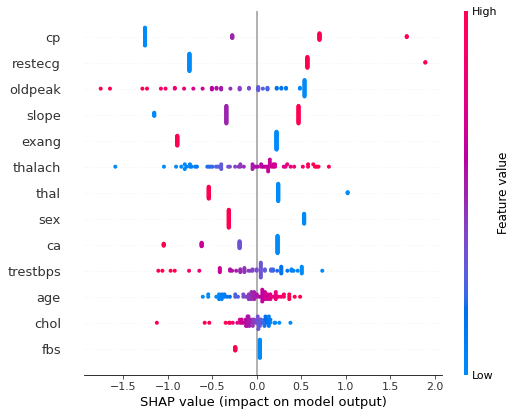

In [52]:
shap.initjs()
shap.summary_plot(shap_values, x_test)

#### The linear model results in a linear depndence_plot

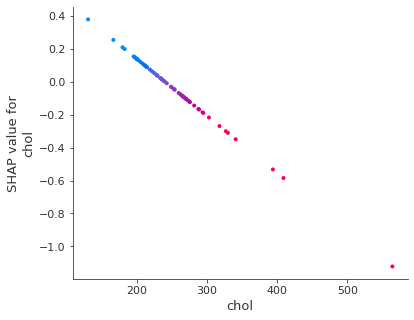

In [53]:
shap.initjs()
shap.dependence_plot(ind='chol', interaction_index='chol',
                     shap_values=shap_values, 
                     features=x_test)